In [2]:
!nvidia-smi

Mon Sep  5 10:57:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Add,
    Dense,
    Conv2D,
    GlobalAveragePooling1D,
    Layer,
    LayerNormalization,
    Permute,
    Softmax,
    Activation,
    Dropout
)
from tensorflow.keras import callbacks
from keras.models import Sequential
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

### MlpBlock

In [4]:
class MlpBlock(Layer):
    """
    this Block consists of 2 Linear Blocks, with Dropout, and Activation
    """    
    def __init__(self, dim:int,
     hidden_dim:int, 
     activation:Activation =keras.activations.gelu, 
     drop:float =0, 
     **kwargs
    )->None:
        """
        Constructs all necessary attributes for the MlpBlock object

        Args:
            dim (int): shows dimension of the output feature map 
            hidden_dim (int): represents the dimension of the bottleneck feature map
            activation (Activation, optional): Activation function. Defaults to keras.activations.gelu.
            drop (float, optional): if drop>0 means apply dropout with rate equals drop . Defaults to 0.
        """                
        super(MlpBlock, self).__init__(**kwargs)
        hidden_dim = hidden_dim or dim
        self.mlp = Sequential([
            Dense(hidden_dim), 
            Activation(activation), 
            Dropout(drop),
            Dense(dim), 
            Dropout(drop)          
        ])
    
    def call(self, inputs:tf.Tensor) ->tf.Tensor:
        """
         calculates the output featuremap after applying MlpBlock

        Args:
            inputs (tf.Tensor): inputs of MlpBlock, that we want to apply 2 Linear layer sequentially to inputs

        Returns:
            tf.Tensor: output of the MlpBlock after applying 2 sequential Linear layers to the inputs
        """        
        return self.mlp(inputs)
        
    def compute_output_shape(self, input_signature):
        return (input_signature[0], self.dim)

    def get_config(self):
        config = super(MlpBlock, self).get_config()
        config.update({
            'dim': self.dim,
            'hidden_dim': self.hidden_dim
        })
        return config

### MixerBlock

In [5]:
class MixerBlock(Layer):
    '''applies token_mixer module and channel_mixing module sequentially
    '''
    def __init__(
        self, 
        num_patches:int, 
        channel_dim:int,
        token_mixer_hidden_dim:int, 
        channel_mixer_hidden_dim:int = None, 
        activation:Activation = keras.activations.gelu, 
        **kwargs
    )->None:
        """
       Constructs all necessary variables fo MixerBlock

        Args:
            num_patches (int): shows number of patches in the input feature map
            channel_dim (int): shows channels dimension in the input feature map
            token_mixer_hidden_dim (int): dimension of the hidden layer in token_mixer module
            channel_mixer_hidden_dim (int, optional): dimension of the hidden layer in channel_mixer module. Defaults to None.
            activation (Activation, optional): activation function which is applied in MlpBlocks after first Linear layer. Defaults to keras.activations.gelu.
        """        
        super(MixerBlock, self).__init__(**kwargs)
        
        self.num_patches = num_patches
        self.channel_dim = channel_dim
        self.token_mixer_hidden_dim = token_mixer_hidden_dim
        self.activation = activation
        self.channel_mixer_hidden_dim = channel_mixer_hidden_dim or self.token_mixer_hidden_dim

        self.token_mixer = Sequential([
            LayerNormalization(axis=1), 
            Permute((2, 1)), 
            MlpBlock(self.num_patches, self.token_mixer_hidden_dim), 
            Permute((2, 1)), 
        ])
        self.channel_mixer = Sequential([
            LayerNormalization(axis=1), 
            MlpBlock(self.channel_dim, channel_mixer_hidden_dim)
        ])
    def call(self, inputs:tf.Tensor) ->tf.Tensor:
        """
        applies token_mixer module and channel_mixer module sequentially to the inputs and returns the output tensor

        Args:
            inputs (tf.Tensor): tensor which is given to the MixerBlock as an input

        Returns:
            tf.Tensor: output after applying the  token_mixer and the channel_mixer module
        """        
        skip_x = inputs
        token_mixer_output = self.token_mixer(inputs)

        skip_x = skip_x + token_mixer_output
        channel_mixer_output = self.channel_mixer(skip_x)

        skip_x = skip_x + channel_mixer_output
        channel_mixer_output = self.channel_mixer(skip_x)
        x = skip_x + channel_mixer_output
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(MixerBlock, self).get_config()
        config.update({
            'num_patches': self.num_patches,
            'channel_dim': self.channel_dim,
            'token_mixer_hidden_dim': self.token_mixer_hidden_dim,
            'channel_mixer_hidden_dim': self.channel_mixer_hidden_dim,
            'activation': self.activation,
        })
        return config

### MlpMixerBlock

In [6]:
def MlpMixerModel(
        input_shape: int,
        num_classes: int,
        num_blocks: int,
        patch_size: int,
        hidden_dim: int,
        tokens_mlp_dim: int,
        channels_mlp_dim: int = None,
        use_softmax: bool = False,
):
    height, width, _ = input_shape

    if channels_mlp_dim is None:
        channels_mlp_dim = tokens_mlp_dim

    num_patches = (height*width)//(patch_size**2)  

    inputs = keras.Input(input_shape)
    x = inputs

    x = Conv2D(hidden_dim,
               kernel_size=patch_size,
               strides=patch_size,
               padding='same',
               name='projector')(x)

    x = keras.layers.Reshape([-1, hidden_dim])(x)

    for _ in range(num_blocks):
        x = MixerBlock(num_patches=num_patches,
                       channel_dim=hidden_dim,
                       token_mixer_hidden_dim=tokens_mlp_dim,
                       channel_mixer_hidden_dim=channels_mlp_dim)(x)

    x = GlobalAveragePooling1D()(x) 

    x = LayerNormalization(name='pre_head_layer_norm')(x)
    x = Dense(num_classes, name='head')(x)

    if use_softmax:
        x = Softmax()(x)
    return keras.Model(inputs, x)

### callbacks

In [7]:
!mkdir files

In [8]:
model_path = './files/model.h5'
csv_path = "./files/data.csv"

In [9]:
my_callbacks = [
        callbacks.ModelCheckpoint(model_path),      # create_dir(files)
        callbacks.CSVLogger(csv_path),
        callbacks.TensorBoard(),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
        callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
    ]  

### Hyperparameters

In [10]:
batch_size=16
num_blocks=4
patch_size=8
hidden_dim=32
tokens_mlp_dim=64
channels_mlp_dim=128
num_epochs = 300

### Training

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_val = x_train[:40000], x_train[40000:]
y_train, y_val = y_train[:40000], y_train[40000:]
model = MlpMixerModel(input_shape=x_train.shape[1:],
                      num_classes=len(np.unique(y_train)), 
                      num_blocks=num_blocks, 
                      patch_size=patch_size,
                      hidden_dim=hidden_dim, 
                      tokens_mlp_dim=tokens_mlp_dim,
                      channels_mlp_dim=channels_mlp_dim,
                      use_softmax=True)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='acc')
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=num_epochs, callbacks=[my_callbacks], batch_size=batch_size)

170508288/170498071 [==============================] - 2s 0us/step
Epoch 1/300
2500/2500 [==============================] - 49s 13ms/step - loss: 2.0051 - acc: 0.2575 - val_loss: 1.8061 - val_acc: 0.3376 - lr: 0.0010
Epoch 2/300
2500/2500 [==============================] - 30s 12ms/step - loss: 1.6987 - acc: 0.3860 - val_loss: 1.6441 - val_acc: 0.4045 - lr: 0.0010
Epoch 3/300
2500/2500 [==============================] - 30s 12ms/step - loss: 1.5704 - acc: 0.4387 - val_loss: 1.5221 - val_acc: 0.4590 - lr: 0.0010
Epoch 4/300
2500/2500 [==============================] - 31s 13ms/step - loss: 1.4800 - acc: 0.4732 - val_loss: 1.4845 - val_acc: 0.4705 - lr: 0.0010
Epoch 5/300
2500/2500 [==============================] - 30s 12ms/step - loss: 1.4185 - acc: 0.4947 - val_loss: 1.4188 - val_acc: 0.4955 - lr: 0.0010
Epoch 6/300
2500/2500 [==============================] - 31s 12ms/step - loss: 1.3707 - acc: 0.5107 - val_loss: 1.3838 - val_acc: 0.5116 - lr: 0.0010
Epoch 7/300
2500/2500 [==========

### ploting results

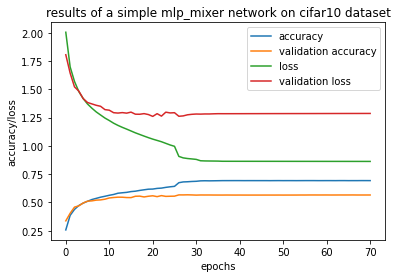

In [14]:
def plot_train_results():
    '''plot the training results'''
    csv = pd.read_csv(os.path.join(os.getcwd(), 'files/data.csv'))
    plt.plot(csv['acc'], label='accuracy')
    plt.plot(csv['val_acc'], label='validation accuracy')
    plt.plot(csv['loss'], label='loss')
    plt.plot(csv['val_loss'], label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('accuracy/loss')
    plt.title('results of a simple mlp_mixer network on cifar10 dataset')
    plt.legend()
    plt.show()

plot_train_results()

### Test

In [13]:
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'MixerBlock':MixerBlock})
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1.0000e-06), loss='sparse_categorical_crossentropy', metrics='acc')
loss, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)
print('accuracy: ', accuracy)
print('loss: ', loss)

625/625 [==============================] - 4s 5ms/step - loss: 1.2938 - acc: 0.5693
accuracy:  0.5692999958992004
loss:  1.2937959432601929
